In [ ]:
!gdown 1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
!unzip -q icdar2003.zip -d datasets

Downloading...
From (original): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV
From (redirected): https://drive.google.com/uc?id=1kUy2tuH-kKBlFCNA0a9sqD2TG4uyvBnV&confirm=t&uuid=c160c908-f350-437c-9f5a-d82830d05c90
To: /content/icdar2003.zip
100% 45.7M/45.7M [00:00<00:00, 92.4MB/s]


##### Import các thư viện cần thiết

In [ ]:
import os
import random
import time
import xml.etree.ElementTree as ET

import cv2
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

##### Chuẩn bị bộ dữ liệu

In [ ]:
def extract_data_from_xml(path):
    tree = ET.parse(path)
    root = tree.getroot()

    image_paths = []
    image_sizes = []
    image_labels = []
    bounding_boxes = []

    for image in root:
        bbs_of_image = []
        labels_of_image = []

        for bbs in image.findall("taggedRectangles"):
            for bb in bbs:
                # check non-alphabet and non-number
                if not bb[0].text.isalnum():
                    continue

                if "é" in bb[0].text.lower() or "ñ" in bb[0].text.lower():
                    continue

                bbs_of_image.append(
                    [
                        float(bb.attrib["x"]),
                        float(bb.attrib["y"]),
                        float(bb.attrib["width"]),
                        float(bb.attrib["height"]),
                    ]
                )
                labels_of_image.append(bb[0].text.lower())

        image_paths.append(image[0].text)
        image_sizes.append((int(image[1].attrib["x"]), int(image[1].attrib["y"])))
        bounding_boxes.append(bbs_of_image)
        image_labels.append(labels_of_image)

    return image_paths, image_sizes, image_labels, bounding_boxes

In [ ]:
dataset_dir = "datasets/SceneTrialTrain/"
words_xml_path = os.path.join(dataset_dir, "words.xml")
img_paths, img_sizes, img_labels, bboxes = extract_data_from_xml(
    words_xml_path
)

In [ ]:
def split_bounding_boxes(img_paths, img_labels, bboxes, dataset_dir, save_dir):
    os.makedirs(save_dir, exist_ok=True)

    count = 0
    labels = []

    for img_path, img_label, bbs in zip(img_paths, img_labels, bboxes):
        img_path = os.path.join(dataset_dir, img_path)
        img = Image.open(img_path)

        for label, bb in zip(img_label, bbs):
            # crop image
            cropped_img = img.crop((bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]))

            # filter out if 90% the cropped image is black or white
            if np.mean(cropped_img) < 35 or np.mean(cropped_img) > 220:
                continue

            if cropped_img.size[0] < 10 or cropped_img.size[1] < 10:
                continue

            # save image

            filename = f'{count:06d}.jpg'
            cropped_img.save(os.path.join(save_dir, filename))

            new_img_path = os.path.join(save_dir, filename)
            label = new_img_path + '\t' + label
            labels.append(label)
            count += 1
    print(f'Created {count} images')

    # write labels to a text file
    with open(os.path.join(save_dir, 'labels.txt'), 'w') as f:
        for label in labels:
            f.write(f'{label}\n')

In [ ]:
save_dir = 'datasets/ocr_dataset/'
split_bounding_boxes(img_paths, img_labels, bboxes, dataset_dir, save_dir)

Created 1088 images


##### Đọc dữ liệu

In [ ]:
root_dir = save_dir

img_paths, labels = [], []

# read labels from text file
with open(os.path.join(root_dir, 'labels.txt'), 'r') as f:
    for label in f:
        labels.append(label.strip().split('\t')[1])
        img_paths.append(label.strip().split('\t')[0])

print(f'Total images: {len(img_paths)}')

Total images: 1088


##### Xây dựng bộ từ vựng

In [ ]:
labels

['self',
 'adhesive',
 'address',
 'labels',
 '36',
 '250',
 'on',
 'a',
 'roll',
 'natwest',
 'greek',
 'gastronomy',
 'cookery',
 'wines',
 'local',
 'toubrs',
 'specialties',
 'festive',
 'recipes',
 'illustrated',
 '83',
 '73',
 'the',
 'house',
 'of',
 'the',
 'spirits',
 'isabel',
 'allende',
 'intensely',
 'moving',
 'both',
 'entertaining',
 'and',
 'deeply',
 'serious',
 'evening',
 'standard',
 'digital',
 'multimedia',
 'wiley',
 'nigel',
 'chapman',
 'and',
 'jenny',
 'chapman',
 'software',
 'design',
 'for',
 'systems',
 'j',
 'e',
 'cooling',
 'nokia',
 'adapter',
 'cable',
 'dlr',
 '3p',
 'a4382',
 'nokia',
 '6210',
 'dlr',
 '3p',
 'data',
 'cable',
 'professional',
 'issues',
 'in',
 'software',
 'engineering',
 'frank',
 'bott',
 'allison',
 'coleman',
 'jack',
 'eaton',
 'diane',
 'rowland',
 'third',
 'edition',
 'silberschatz',
 'galvin',
 'operating',
 'system',
 'concepts',
 'fifth',
 'edition',
 'systems',
 'series',
 'systems',
 'analysis',
 'design',
 'stems',

In [ ]:
letters = [char.split('.')[0].lower() for char in labels]
letters = ''.join(letters)
letters = sorted(list(set(list(letters))))

# create a string of all characters in the dataset
chars = ''.join(letters)

# for 'blank' character
blank_char = '-'
chars += blank_char
vocab_size = len(chars)
print(f'Vocab: {chars}')
print(f'Vocab size: {vocab_size}')

Vocab: 0123456789abcdefghijklmnopqrstuvwxyz-
Vocab size: 37


In [ ]:
char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(chars))}
idx_to_char = {index: char for char, index in char_to_idx.items()}

In [ ]:
char_to_idx

{'-': 1,
 '0': 2,
 '1': 3,
 '2': 4,
 '3': 5,
 '4': 6,
 '5': 7,
 '6': 8,
 '7': 9,
 '8': 10,
 '9': 11,
 'a': 12,
 'b': 13,
 'c': 14,
 'd': 15,
 'e': 16,
 'f': 17,
 'g': 18,
 'h': 19,
 'i': 20,
 'j': 21,
 'k': 22,
 'l': 23,
 'm': 24,
 'n': 25,
 'o': 26,
 'p': 27,
 'q': 28,
 'r': 29,
 's': 30,
 't': 31,
 'u': 32,
 'v': 33,
 'w': 34,
 'x': 35,
 'y': 36,
 'z': 37}

In [ ]:
max_label_len = max([len(label) for label in labels])

def encode(label, char_to_idx, max_label_len):
    encoded_labels = torch.tensor(
        [char_to_idx[char] for char in label],
        dtype=torch.int32
    )
    label_len = len(encoded_labels)
    lengths = torch.tensor(
        label_len,
        dtype=torch.int32
    )
    padded_labels = F.pad(
        encoded_labels,
        (0, max_label_len - label_len),
        value=0
    )

    return padded_labels, lengths

In [ ]:
def decode(encoded_sequences, idx_to_char, blank_char='-'):
    decoded_sequences = []
    for seq in encoded_sequences:
        decoded_label = []
        prev_char = None

        for token in seq:
            if token != 0:
                char = idx_to_char[token.item()]
                if char != blank_char:
                    if char != prev_char or prev_char == blank_char:
                        decoded_label.append(char)
                prev_char = char
        decoded_sequences.append(''.join(decoded_label))
    print(f'From {encoded_sequences} to {decoded_sequences}')
    return decoded_sequences

##### Tiền xử lý dữ liệu

In [ ]:
data_transforms = {
    "train": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.ColorJitter(
                brightness=0.5,
                contrast=0.5,
                saturation=0.5,
            ),
            transforms.Grayscale(
                num_output_channels=1,
            ),
            transforms.GaussianBlur(3),
            transforms.RandomAffine(
                degrees=1,
                shear=1,
            ),
            transforms.RandomPerspective(
                distortion_scale=0.3,
                p=0.5,
                interpolation=3,
            ),
            transforms.RandomRotation(degrees=2),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
    "val": transforms.Compose(
        [
            transforms.Resize((100, 420)),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ]
    ),
}

In [ ]:
seed = 0
val_size = 0.1
test_size = 0.1
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    img_paths,
    labels,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train,
    y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

In [ ]:
class STRDataset(Dataset):
    def __init__(self, X, y, char_to_idx, max_label_len,
                 label_encoder=None, transform=None):
        self.transform = transform
        self.img_paths = X
        self.labels = y
        self.char_to_idx = char_to_idx
        self.max_label_len = max_label_len
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')

        if self.transform:
            img = self.transform(img)

        if self.label_encoder:
            encoded_label, label_len = self.label_encoder(
                label, self.char_to_idx, self.max_label_len
            )
        return img, encoded_label, label_len

In [ ]:
train_dataset = STRDataset(
    X_train, y_train ,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['train']
)
val_dataset = STRDataset(
    X_val, y_val ,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)
test_dataset = STRDataset(
    X_test, y_test ,
    char_to_idx=char_to_idx,
    max_label_len=max_label_len,
    label_encoder=encode,
    transform=data_transforms['val']
)

train_bacth_size = 64
test_batch_size = 64*2

train_loader = DataLoader(
    train_dataset,
    batch_size=train_bacth_size,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

In [ ]:
class CRNN(nn.Module):
    def __init__(
        self, vocab_size, hidden_size, n_layers, dropout=0.2, unfreeze_layers=3
    ):
        super(CRNN, self).__init__()

        backbone = timm.create_model("resnet34", in_chans=1, pretrained=True)
        modules = list(backbone.children())[:-2]
        modules.append(nn.AdaptiveAvgPool2d((1, None)))
        self.backbone = nn.Sequential(*modules)

        # Unfreeze the last few layers
        for parameter in self.backbone[-unfreeze_layers:].parameters():
            parameter.requires_grad = True

        self.mapSeq = nn.Sequential(
            nn.Linear(512, 512), nn.ReLU(), nn.Dropout(dropout)
        )

        self.gru = nn.GRU(
            512,
            hidden_size,
            n_layers,
            bidirectional=True,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.layer_norm = nn.LayerNorm(hidden_size * 2)

        self.out = nn.Sequential(
            nn.Linear(hidden_size * 2, vocab_size), nn.LogSoftmax(dim=2)
        )

    @torch.autocast(device_type="cuda")
    def forward(self, x):
        x = self.backbone(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)  # Flatten the feature map
        x = self.mapSeq(x)
        x, _ = self.gru(x)
        x = self.layer_norm(x)
        x = self.out(x)
        x = x.permute(1, 0, 2)  # Based on CTC

        return x

In [ ]:
hidden_size = 256
n_layers = 3
dropout_prob = 0.2
unfreeze_layers = 3
device = "cuda" if torch.cuda.is_available() else "cpu"

model = CRNN(
    vocab_size=vocab_size,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout=dropout_prob,
    unfreeze_layers=unfreeze_layers,
).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels, labels_len in dataloader:
            inputs, labels, labels_len = inputs.to(device), labels.to(device), labels_len.to(device)

            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1), ),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels, logits_lens, labels_len)
            losses.append(loss.item())

    loss = sum(losses) / len(losses)
    return loss

In [ ]:
def fit (
        model, train_loader, val_loader, criterion, optimizer, scheduler,
        device, epochs
):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        start = time.time()
        batch_train_losses = []

        model.train()
        for idx, (inputs, labels, labels_len) in enumerate(train_loader):
            inputs, labels, labels_len = inputs.to(device), labels.to(device), labels_len.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            logits_lens = torch.full(
                size=(outputs.size(1), ),
                fill_value=outputs.size(0),
                dtype=torch.long
            ).to(device)

            loss = criterion(outputs, labels.cpu(), logits_lens.cpu(), labels_len.cpu())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            optimizer.step()

            batch_train_losses.append(loss.item())
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\t\tTime: {time.time() - start:.2f} seconds')
        scheduler.step()
    return train_losses, val_losses

In [ ]:
epochs = 100
lr = 1e-3
weight_decay = 1e-5
scheduler_step_size = epochs * 0.5

criterion = nn.CTCLoss(
    blank=char_to_idx[blank_char],
    zero_infinity=True,
    reduction="mean",
)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    weight_decay=weight_decay,
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=scheduler_step_size, gamma=0.1
)

In [ ]:
train_losses, val_losses = fit(
    model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs
)

4.487504175731114
3.5493385791778564
EPOCH 1:	Train loss: 4.4875	Val loss: 3.5493		Time: 9.50 seconds
3.4670799800327847
3.677572011947632
EPOCH 2:	Train loss: 3.4671	Val loss: 3.6776		Time: 7.51 seconds
3.415831548827035
3.4799113273620605
EPOCH 3:	Train loss: 3.4158	Val loss: 3.4799		Time: 8.69 seconds
3.4089832987104143
3.3785476684570312
EPOCH 4:	Train loss: 3.4090	Val loss: 3.3785		Time: 6.97 seconds
3.2991936206817627
3.279534339904785
EPOCH 5:	Train loss: 3.2992	Val loss: 3.2795		Time: 7.95 seconds
3.1391967705317905
3.136004686355591
EPOCH 6:	Train loss: 3.1392	Val loss: 3.1360		Time: 9.34 seconds
2.9831468718392506
2.9767768383026123
EPOCH 7:	Train loss: 2.9831	Val loss: 2.9768		Time: 7.43 seconds
2.667393275669643
2.7399051189422607
EPOCH 8:	Train loss: 2.6674	Val loss: 2.7399		Time: 7.81 seconds
2.341617856706892
2.3303494453430176
EPOCH 9:	Train loss: 2.3416	Val loss: 2.3303		Time: 6.86 seconds
2.0096249750682285
1.9939038753509521
EPOCH 10:	Train loss: 2.0096	Val loss: 1.9

Text(0.5, 1.0, 'Val Loss')

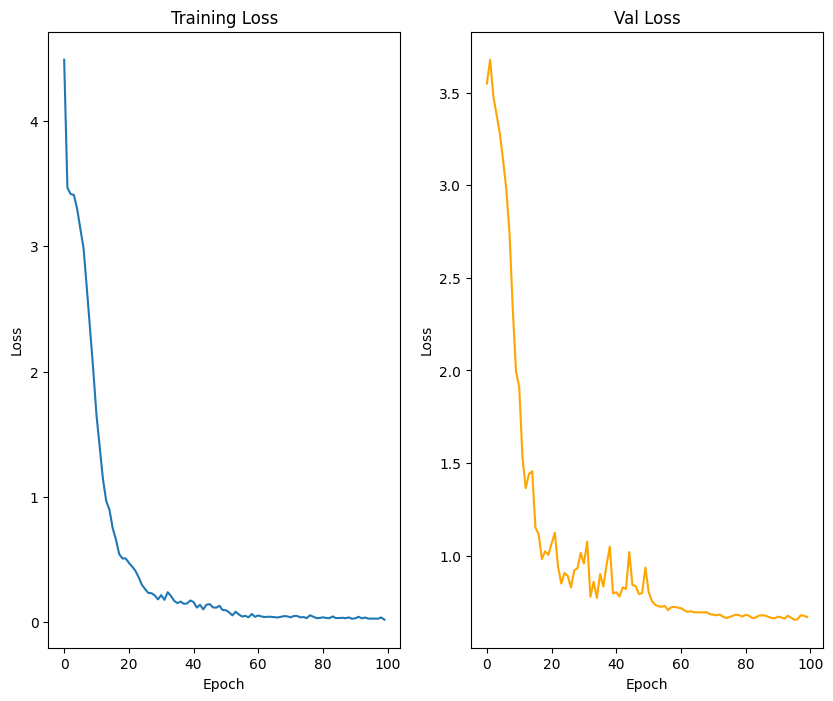

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 8))
ax[0].plot(train_losses)
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Training Loss')

ax[1].plot(val_losses, color='orange')
ax[1].set(xlabel='Epoch', ylabel='Loss')
ax[1].set_title('Val Loss')

In [ ]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print('Evaluation on val/test dataset')
print('Val loss: ', val_loss)
print('Test loss: ', test_loss)

Evaluation on val/test dataset
Val loss:  0.6687290072441101
Test loss:  1.514941930770874


In [ ]:
torch.save(model.state_dict(), 'crnn.pt')